In [15]:
!pip install aisaratuners

In [16]:
from aisaratuners.aisara_keras_tuner import Hp, HpOptimization
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from google.colab import files

In [3]:
# uploaded = files.upload()

Saving datasets_33180_43520_heart.csv to datasets_33180_43520_heart.csv


In [17]:
# load heart disease dataset
dataset=pd.read_csv('/content/datasets_33180_43520_heart.csv')
dataset.columns=['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'serum_cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate',
       'exercise_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']
dataset.chest_pain_type = dataset.chest_pain_type.map({1:'angina pectoris', 2:'atypical angina', 3:'non-anginal pain', 4:'SMI', 0:'absent'})
dataset.st_slope = dataset.st_slope.map({1:'upsloping', 2:'horizontal', 3:'downsloping', 0:'absent'})
dataset.thalassemia = dataset.thalassemia.map({1:'normal', 2:'fixed defect', 3:'reversable defect', 0:'absent'})
dataset

,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate,exercise_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,1,non-anginal pain,145,233,1,0,150,0,2.3,absent,0,normal,1
1,37,1,atypical angina,130,250,0,1,187,0,3.5,absent,0,fixed defect,1
2,41,0,angina pectoris,130,204,0,0,172,0,1.4,horizontal,0,fixed defect,1
3,56,1,angina pectoris,120,236,0,1,178,0,0.8,horizontal,0,fixed defect,1
4,57,0,absent,120,354,0,1,163,1,0.6,horizontal,0,fixed defect,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,absent,140,241,0,1,123,1,0.2,upsloping,0,reversable defect,0
299,45,1,non-anginal pain,110,264,0,1,132,0,1.2,upsloping,0,reversable defect,0
300,68,1,absent,144,193,1,1,141,0,3.4,upsloping,2,reversable defect,0
301,57,1,absent,130,131,0,1,115,1,1.2,upsloping,1,reversable defect,0


In [18]:
# check for null values and drop if any 
dataset.isnull().sum()

age                       0
sex                       0
chest_pain_type           0
resting_blood_pressure    0
serum_cholesterol         0
fasting_blood_sugar       0
rest_ecg                  0
max_heart_rate            0
exercise_angina           0
st_depression             0
st_slope                  0
num_major_vessels         0
thalassemia               0
target                    0
dtype: int64

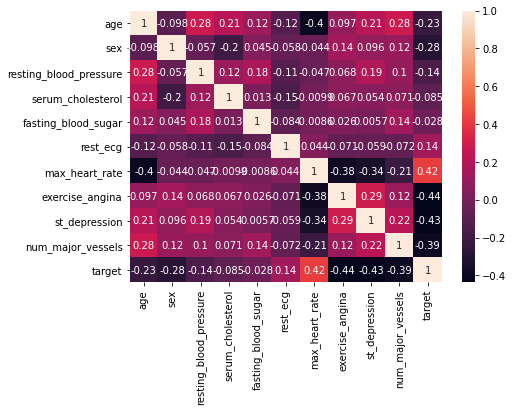

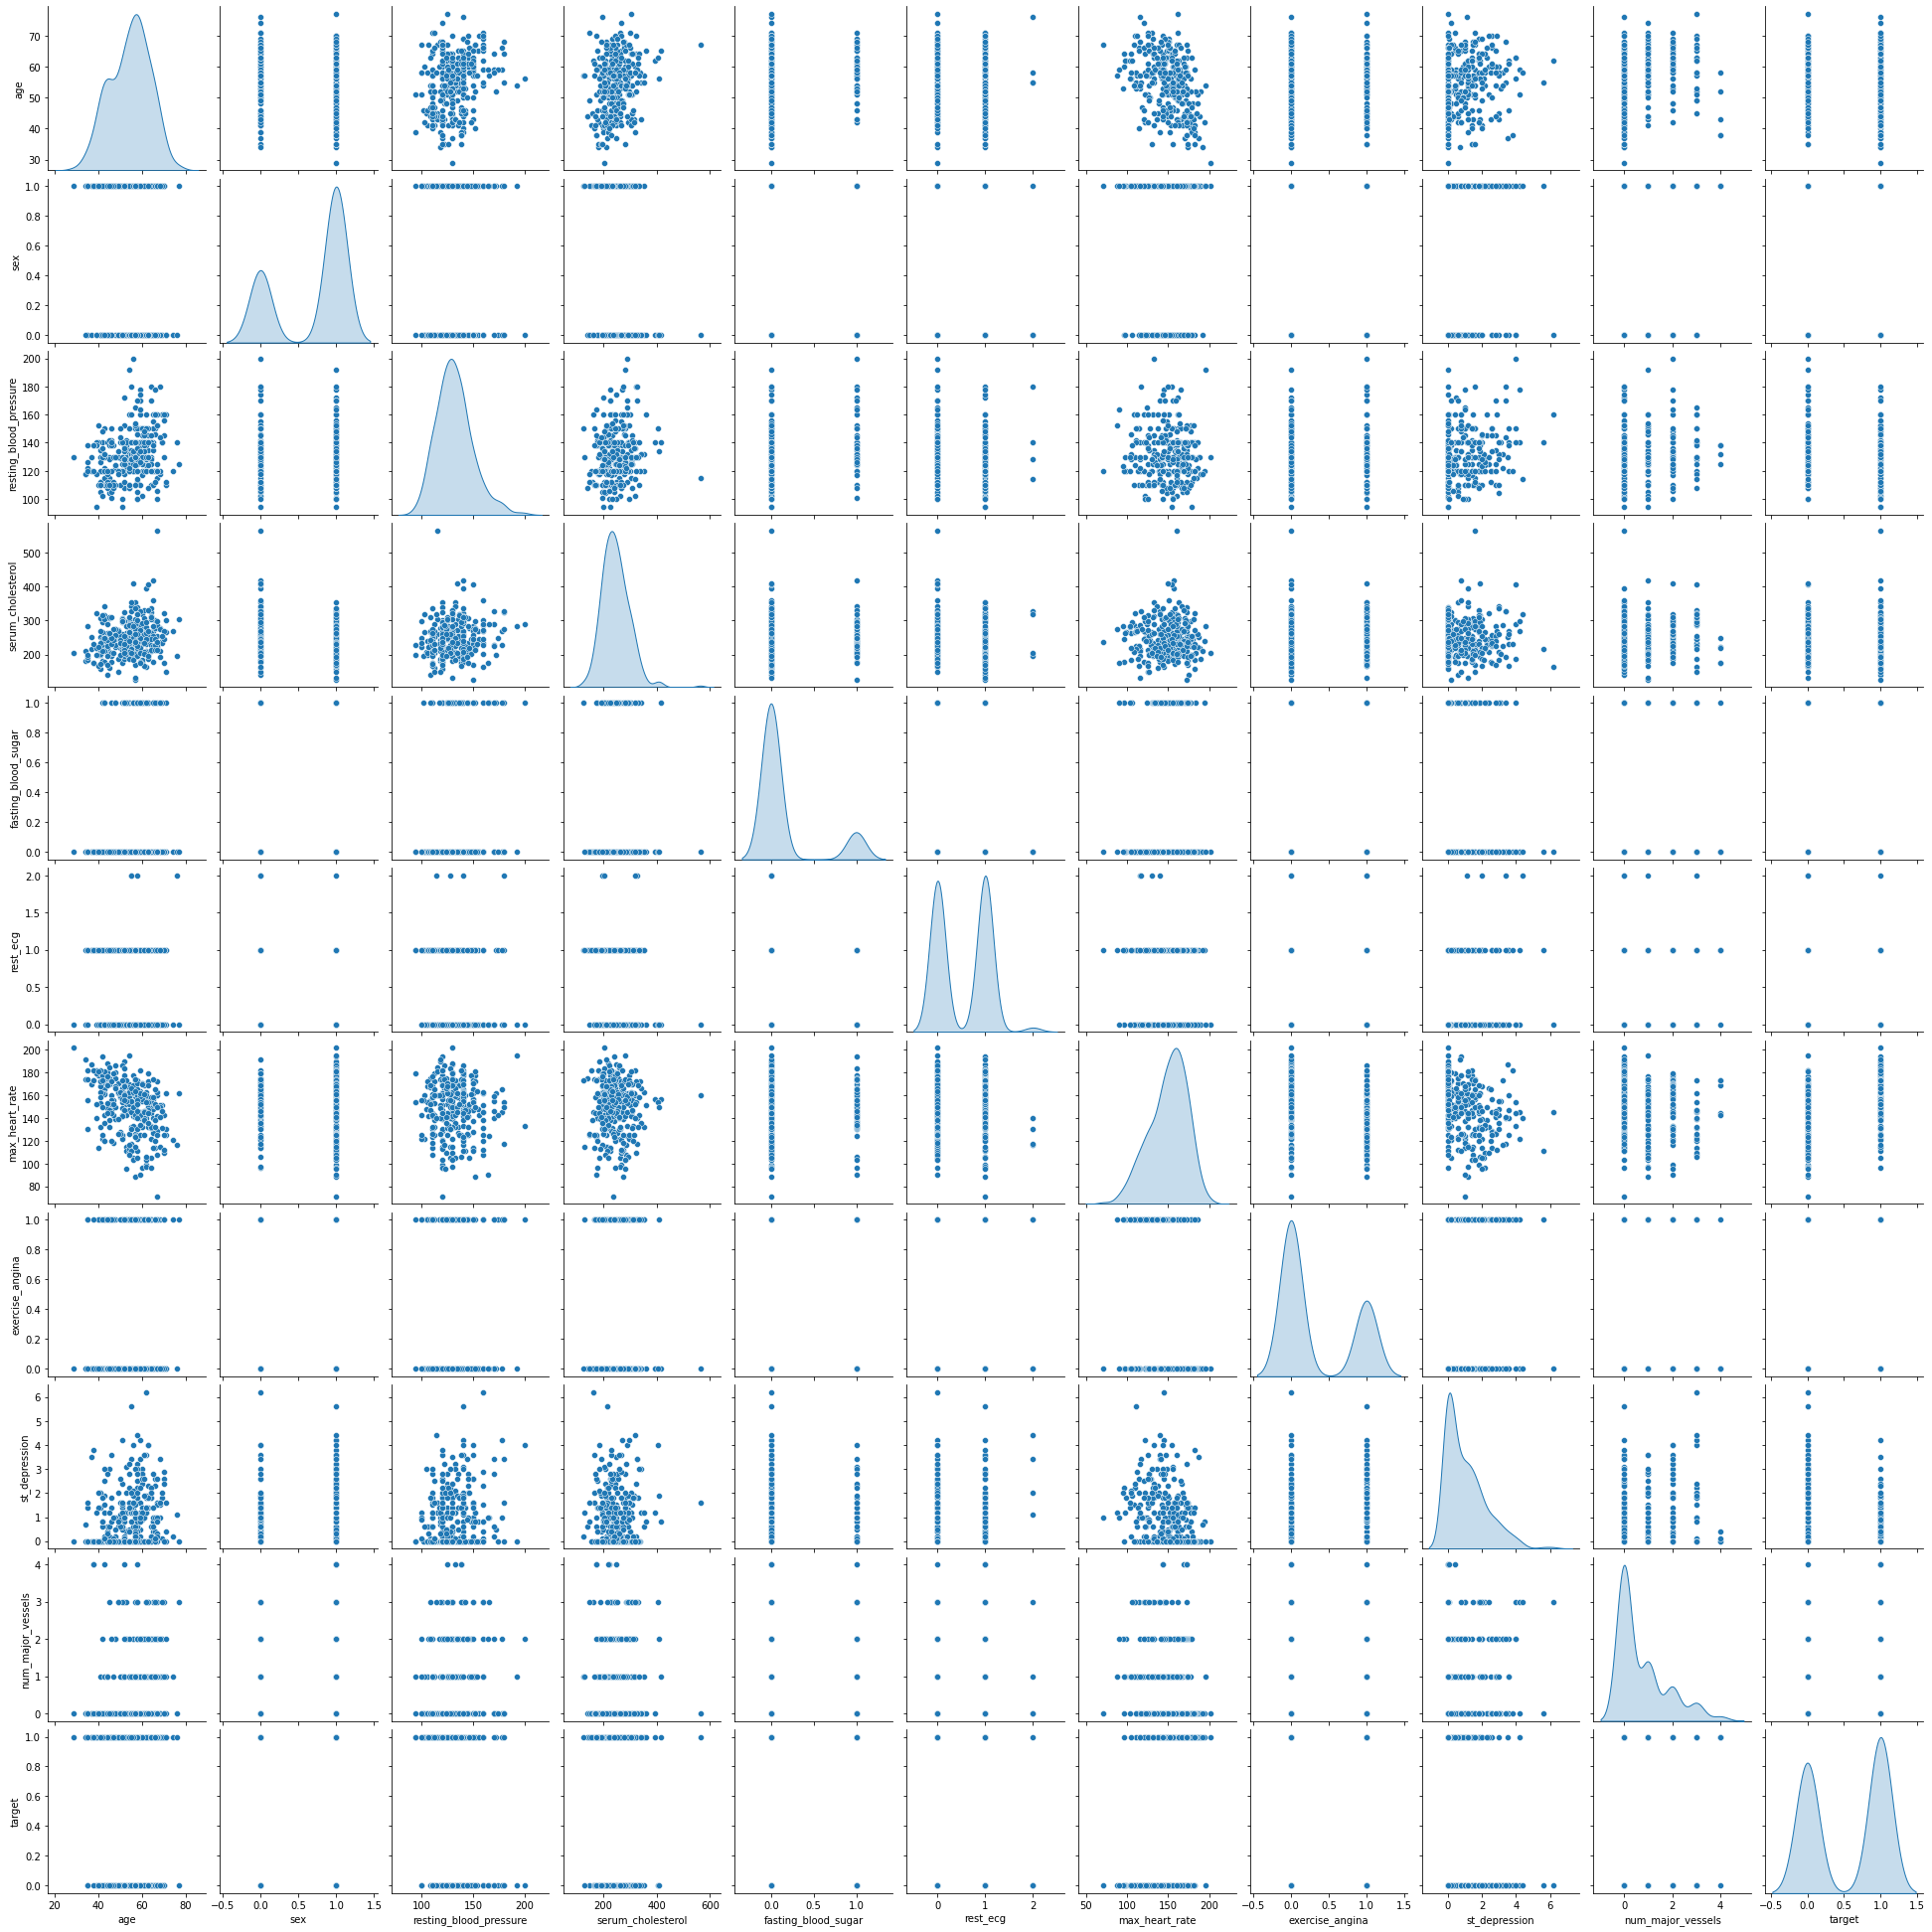

In [19]:
# correlation heatmap
figure(figsize=(7, 5))
corrMatrix = dataset.corr()
sns.heatmap(corrMatrix, annot=True);

# pairplot
sns.pairplot(dataset, diag_kind="kde");

In [20]:
# create dummies for categorical attributes
categorical_columns = ['chest_pain_type', 'thalassemia', 'st_slope']
for column in categorical_columns:
    dummies = pd.get_dummies(dataset[column])
    dataset[dummies.columns] = dummies
    dataset.drop(column, axis =1, inplace = True)

In [21]:
# split data (train and test) and data normalization
train_dataset = dataset.sample(frac=0.8)
test_dataset = dataset.drop(train_dataset.index)
train_stats = train_dataset.describe()
train_stats.pop("target")
train_stats = train_stats.transpose()
train_labels = train_dataset.pop('target')
test_labels = test_dataset.pop('target')
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [22]:
# define Hps:
my_hps = Hp()
hp_1 = my_hps.numrange(name='num_nodes_hidd1',min=32,max=256)
hp_2 = my_hps.numrange(name='num_nodes_hidd2',min=32,max=256)
hp_3 = my_hps.numrange(name='lr',min=0.0001,max=0.01, type='log')

In [23]:
# define keras model and return model history
def myfunc(comp, k):
    model = Sequential()
    model.add(Dense(200, activation ='relu',input_shape=[len(train_dataset.keys())]))
    model.add(Dense(comp['num_nodes_hidd1'][k], activation = 'relu'))
    model.add(Dense(comp['num_nodes_hidd2'][k], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(comp['lr'][k]), metrics=['acc'])
    history = model.fit(normed_train_data, train_labels, epochs=15, validation_data=(normed_test_data,test_labels))
    return model, history

In [24]:
# run optimizer
demo = HpOptimization(my_hps, myfunc, ['val_acc','val_loss'], ['max','min'], num_trials = 10, rounds = 3, mode='p')
demo.run_opti()

For commercial use, you can obtain our API from https://rapidapi.com/aisara-technology-aisara-technology-default/api/aisara-hyperparameter-tuning
If you are a private user, set the mode parameter in HpOptimization class to "p".

Round-1:

  Run-1:
Train on 242 samples, validate on 61 samples
Epoch 1/15
242/242 [==============================] - 0s 655us/sample - loss: 0.7090 - acc: 0.4669 - val_loss: 0.7133 - val_acc: 0.4754
Epoch 2/15
242/242 [==============================] - 0s 104us/sample - loss: 0.7086 - acc: 0.4669 - val_loss: 0.7130 - val_acc: 0.4754
Epoch 3/15
242/242 [==============================] - 0s 109us/sample - loss: 0.7083 - acc: 0.4669 - val_loss: 0.7128 - val_acc: 0.4754
Epoch 4/15
242/242 [==============================] - 0s 105us/sample - loss: 0.7079 - acc: 0.4669 - val_loss: 0.7125 - val_acc: 0.4754
Epoch 5/15
242/242 [==============================] - 0s 102us/sample - loss: 0.7076 - acc: 0.4711 - val_loss: 0.7123 - val_acc: 0.4754
Epoch 6/15
242/242 [=======

In [25]:
# optimization results in dataframe
print(demo.opti_results)

 num_nodes_hidd1  num_nodes_hidd2        lr      loss       acc  val_loss   val_acc    Round    model ID
             155              178  0.000200  0.704223  0.495868  0.709916  0.491803  Round_1   model_1_1
             200              110  0.003162  0.590224  0.793388  0.608549  0.704918  Round_1   model_1_2
              88              222  0.007943  0.556141  0.842975  0.567839  0.819672  Round_1   model_1_3
              66              245  0.000316  0.683485  0.636364  0.694531  0.475410  Round_1   model_1_4
             222               88  0.000501  0.654620  0.661157  0.663550  0.655738  Round_1   model_1_5
              43              155  0.001259  0.664302  0.710744  0.690096  0.557377  Round_1   model_1_6
             178               43  0.001995  0.633152  0.776860  0.649572  0.655738  Round_1   model_1_7
             245              200  0.000794  0.648514  0.719008  0.644415  0.754098  Round_1   model_1_8
             133               66  0.000126  0.697832  

In [26]:
# visualize optimization results
demo.plot_opti_results()

In [27]:
# visualize hyperparameters search space
demo.plot_search_space()

In [28]:
# best model hyperparameters
print(demo.best_model_hps)

 num_nodes_hidd1  num_nodes_hidd2        lr
              88              222  0.007943


In [29]:
# loading the best model
best = demo.best_model
best.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 200)               4000      
_________________________________________________________________
dense_137 (Dense)            (None, 88)                17688     
_________________________________________________________________
dense_138 (Dense)            (None, 222)               19758     
_________________________________________________________________
dense_139 (Dense)            (None, 1)                 223       
Total params: 41,669
Trainable params: 41,669
Non-trainable params: 0
_________________________________________________________________
